# Implementação de um codigo de Eigenfaces

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
tex2jax: {
inlineMath: [['$','$'], ['\\(','\\)']],
processEscapes: true},
jax: ["input/TeX","input/MathML","input/AsciiMath","output/CommonHTML"],
extensions: ["tex2jax.js","mml2jax.js","asciimath2jax.js","MathMenu.js","MathZoom.js","AssistiveMML.js", "[Contrib]/a11y/accessibility-menu.js"],
TeX: {
extensions: ["AMSmath.js","AMSsymbols.js","noErrors.js","noUndefined.js"],
equationNumbers: {
autoNumber: "AMS"
}
}
});
<!-- Codigo para rodar Latex no Markdow -->
</script>

A Álgebra Linear possui infinitas aplicações, com seus conceitos podendo ser utilizados de maneira criativa para obtenção dos mais diversos resultados.

Dentre essas, está também o que foi o pontapé inicial para o reconhecimento facial por meio de algoritmos, os eigenfaces;

Neste trabalho explicaremos o que é e como funcionam os eigenfaces e também utilizaremos algumas de suas aplicações.

Iniciando o trabalho, o primeiro passo é carregar uma imagem e transforma-la em um vetor, para isso utilizaremos imagens em escala de cinza e tamanho fixo, fazendo com que o processo seja facilitado.

Assim esse trabalho irá explorar o código por trás da obtenção de Eigenfaces partindo de uma base de imagens, e sugerir aplicações para os resultados obtidos.

Iniciando o trabalho, o primeiro passo é carregar uma imagem e transforma-la em um vetor, para isso utilizaremos imagens em escala de cinza e tamanho fixo, fazendo com que o processo seja facilitado.

In [275]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from IPython.display import Markdown as md

Esse codigo para carregar as imagens busca elas em um diretorio de treinamente, salva os nomes dos rostos conforme a organização em pastas, e também deixa as imagens no formato que precisamos.

In [276]:
IMAGE_DIR = 'test-dataset'
DEFAULT_SIZE = [150, 150] 

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_dirs = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for image_dir in image_dirs:
        dir_path = os.path.join(image_path, image_dir)
        image_names = [image for image in os.listdir(dir_path) if not image.startswith('.')]
        for image_name in image_names:
            image = Image.open (os.path.join(dir_path, image_name))
            image = image.convert ("L")
            # resize to given size (if given )
            if (default_size is not None ):
                image = image.resize (default_size , Image.ANTIALIAS )
            images.append(np.asarray (image , dtype =np. uint8 ))
            images_names.append(image_dir)
    return [images,images_names]



In [277]:
[X, nomes] = read_images()

print("Exemplo de como uma imagem está armazenada (X[0]): ")
print(X[0]);print(type(X[0]))
output = "Numero de arrays dentro desse primeiro array (tamanho de X[0]):"
output += "  <br><b>"+str(len(X[0]))+"</b><br>"
output += "Numero de arrays dentro cada um desses arrays interiores (tamanho de X[0][0]):"
output += "  <br><b>"+str(len(X[0][0]))+ "</b>"
output += "<br>"+"Ou seja, cada imagem está armazenada como uma lista com "+str(len(X[0]))+" 'linhas', onde cada linha tem "+str(len(X[0][0]))+" entradas, cada uma correspondente a um pixel da imagem. <br>"
md(output)

Exemplo de como uma imagem está armazenada (X[0]): 
[[255 255 252 ... 107 114 118]
 [253 252 250 ... 104 111 114]
 [247 247 248 ... 100 105 108]
 ...
 [252 250 249 ...  72  63  62]
 [251 251 251 ...  55  53  56]
 [251 251 251 ...  47  50  54]]
<class 'numpy.ndarray'>


Numero de arrays dentro desse primeiro array (tamanho de X[0]):  <br><b>150</b><br>Numero de arrays dentro cada um desses arrays interiores (tamanho de X[0][0]):  <br><b>150</b><br>Ou seja, cada imagem está armazenada como uma lista com 150 'linhas', onde cada linha tem 150 entradas, cada uma correspondente a um pixel da imagem. <br>

Essas imagens são as que estão na pasta de imagens de treinamento, aqui está uma amostra:

In [278]:
# Função para plotar as imagens
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10), just_sample=False):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )


total face-count:  4780


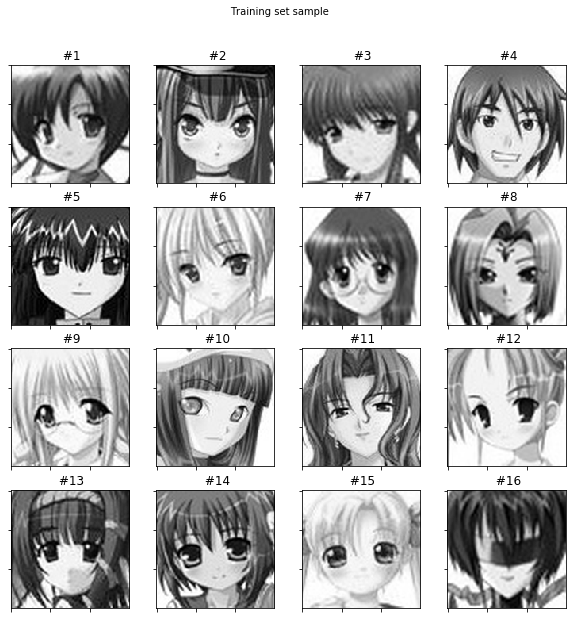

In [279]:
E = []
number = len(X)
for i in range (min(number, 16)):
    E.append(np.asarray(X[i]))
subplot ( title ="Training set sample", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="sample-of-initial-faces.png")
print("total face-count: ",number)

Agora para prosseguir com os calculos precisamos que cada imagem seja um vetor de valores reais, e não uma lista de listas, para isso, as informações dos valores de cada pixel serão ordenados e transformados em um vetor com 250x250=62500 entradas, como ilustra essa imagem do processo de "flattening", ou achatamento:
![Imagem de uma matriz m por n se transformando em um vetor n vezes m por 1](https://images.squarespace-cdn.com/content/v1/5d9292fac5e43353ecec826f/1577637417039-UCB6LZG39YHOMQZB0VMM/fig11.png?format=1500w)
<p style="font-size:8px; color:#bbb">Ilustração retirada de <a>https://www.mccallum-pda.com/mpda-blog/part-2-mineral-model-optimization-using-a-genetic-algorithm</a> encontrada pelo mecanismo de busca do google.</p>

In [280]:
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1)))
    return mat

In [281]:
images_as_rows = as_row_matrix(X)
print("Shape da matriz (colunas = imagens, linhas = pixels da imagem)")
images_as_rows.shape

Shape da matriz (colunas = imagens, linhas = pixels da imagem)


(4780, 22500)

Temos então $ X= \begin{bmatrix}F_1 & F_2 & ... & F_k \end{bmatrix} $
Com cada face $F_i$ sendo $F_{px1}$ e $p$ sendo o nosso numero de pixels por imagem. ($k$ é o nosso numero de imagens de faces.)

Agora que cada imagem é um vetor, é possivel realizar operações entre vetores e exibir um vetor como uma imagem, um exemplo disso é o vetor médio $\mu$, ou a face média, obtida pela media dos vetores:

$\mu = \frac{1}{n}\sum_{i=1}^{n} F_i $

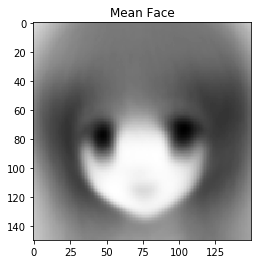

In [282]:
average_weight = np.reshape(images_as_rows.mean(axis =0), DEFAULT_SIZE)
plt.imshow(average_weight, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()

Para prosseguir com o procedimento de busca pelas eigenfaces, o proximo passo é subtrair esse vetor "mean face" das imagens de faces, para termos então o que cada face específica acrescenta de caracteristica nova à face media.
Teremos então  $\phi_i = F_i - \mu$ 

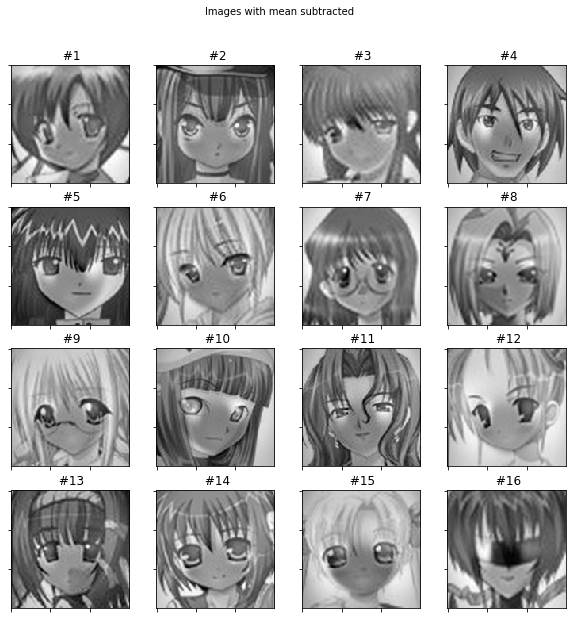

In [283]:
E = []
img_x = X
number = len(img_x)
for i in range (min(number, 16)):
    E.append(np.asarray(img_x[i]-average_weight))
subplot ( title ="Images with mean subtracted", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="images-subtracted-mean.png")

In [284]:
X = images_as_rows
mu = X.mean(axis =0)
phi = X - mu
[n,m] = phi.shape

A partir de $\phi$, montamos uma matriz de Covariancia $C=\phi \phi^T$, que expressa a correlação entre as imagens.<br>
Como $C$ é simétrica (sua simetria fica explicita na sua obtenção mostrada acima), pelo teorema espectral:<br>
$C = Q\Lambda Q^{T}$ =  $\sum \lambda_{i} q_{i}q_{i}^{T}$, 
em que $q_{i}$ é o autovetor de $C$ correspondent ao autovalor $\lambda_{i}$, fazendo com que $C$ seja o resultado de uma soma com os pesos dos termos sendo definidos por seus autovalores. Então é conveniente buscar esses valores que possuem maior impacto na modificação dos valores para montar um algoritmo otimizado, mas que mantenha uma precisão considerável.

In [319]:
if n>m: # Condição para executar o codigo mais rapido. (devido ao custo de calcular phi * phi^T, isso é contornado dessa forma, tirando proveito de que os autovalores da transposta são os mesmos:)
    C = np.dot(phi.T,phi) # Covariance Matrix
    [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    eigenvectors = eigenvectors.T
else :
    C = np.dot (phi,phi.T) # Covariance Matrix
    [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    eigenvectors = np.dot(phi.T, eigenvectors )
    for i in range (n):
        eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    eigenvectors = eigenvectors.T

In [286]:
def fmt(value):
    value = round(value, 2)
    return str(value)

m1=fmt(eigenvalues[0])+r" & 0 & ... & 0 \\ "
m2=" 0 & "+fmt(eigenvalues[1])+r" & ... & 0 \\"
m3=r" ... & ... & ... & ... \\ "
m4=r" 0 & 0 & ... & "+fmt(eigenvalues[-1])
output=r"$\Lambda = \begin{bmatrix}"+m1+m2+m3+m4+r"\end{bmatrix}$"
md(output)

$\Lambda = \begin{bmatrix}-0.0 & 0 & ... & 0 \\  0 & -0.0 & ... & 0 \\ ... & ... & ... & ... \\  0 & 0 & ... & 95731518693.16\end{bmatrix}$

In [287]:
def bvec(vector):
    vecc = r"\begin{bmatrix}"
    vecc += str(round(vector[0],5)) + r"\\"
    vecc += str(round(vector[1],5)) + r"\\"
    vecc += r"..." + r"\\"
    vecc += str(round(vector[-1],5))
    vecc += r"\end{bmatrix}"
    return vecc

output = r"$Q$=$\begin{bmatrix}"
output += bvec(eigenvectors[0]) + r" & " + bvec(eigenvectors[1]) + r" & ... & " + bvec(eigenvectors[-1])
output += r"\end{bmatrix}$"
md(output)

$Q$=$\begin{bmatrix}\begin{bmatrix}0.00623\\0.00744\\...\\0.0123\end{bmatrix} & \begin{bmatrix}-0.01239\\-0.00677\\...\\-0.00655\end{bmatrix} & ... & \begin{bmatrix}-0.00212\\-0.00228\\...\\-0.00532\end{bmatrix}\end{bmatrix}$

Ordenamos agora os autovalores em ordem decrescente, para que nossas matrizes iniciem com os autovalores e autovetores respectivos que possuam maior influencia no valor final da multiplicação.

In [288]:
ordered_index = np.argsort (- eigenvalues )
eigenvalues = eigenvalues [ordered_index] # O autovalor i se torna o elemento de indice i conforme lista de indices ordenados
eigenvectors = eigenvectors [ordered_index] # O autovetor i se torna o vetor de indice i conforme lista de indices ordenados

In [289]:
output = r" $ \Lambda = \begin{bmatrix}"+fmt(eigenvalues[0])+r" & 0 & ... & 0 \\ 0 & "+fmt(eigenvalues[1])+r" & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &"+fmt(eigenvalues[-1])+r" \end{bmatrix}$"
md(output)


 $ \Lambda = \begin{bmatrix}95731518693.16 & 0 & ... & 0 \\ 0 & 31649354742.06 & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &-0.0 \end{bmatrix}$

In [290]:
output = r"$Q$=$\begin{bmatrix}"
output += bvec(eigenvectors[0]) + r" & " + bvec(eigenvectors[1]) + r" & ... & " + bvec(eigenvectors[-1])
output += r"\end{bmatrix}$"
md(output)

$Q$=$\begin{bmatrix}\begin{bmatrix}-0.00212\\-0.00228\\...\\-0.00532\end{bmatrix} & \begin{bmatrix}0.00173\\0.0019\\...\\-0.01543\end{bmatrix} & ... & \begin{bmatrix}0.00623\\0.00744\\...\\0.0123\end{bmatrix}\end{bmatrix}$

Agora, como os valores do final possuem pouca influencia no valor final, podemos descartar parte deles para matermos apenas os componentes principais.

Por esse gráfico podemos perceber o quanto cada autovetor influencia:

In [292]:
def get_eigen_value_distribution(eigenvectors):
    return np.cumsum(eigenvectors) / np.sum(eigenvectors)

def plot_eigen_value_distribution(eigenvectors, interval):
    plt.scatter(interval, get_eigen_value_distribution(eigenvectors)[interval])

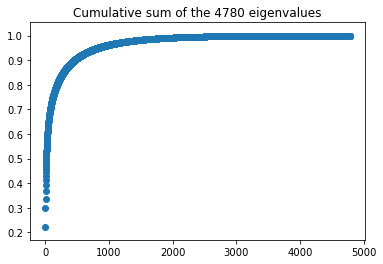

In [293]:
plot_eigen_value_distribution(eigenvalues, range(0, eigenvalues.shape[0]))
plt.title("Cumulative sum of the {0} eigenvalues".format(eigenvalues.shape[0]))
plt.show()

É perceptível que os valores mais a direita estão acrescentando pouco ao resultado, e que se fossem somados os valores até, por exemplo, 75% do total, teriamos aproximadamente o mesmo resultado.

Para escolher o número ideal de autovetores a serem mantidos, estou utilizando esse trecho de codigo que faz a seleção de modo a preservar uma "precisão" de 95%.

In [294]:
def get_number_of_components_to_preserve_variance(eigenvalues, variance=.95):
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            return ii

In [295]:
num_components = get_number_of_components_to_preserve_variance(eigenvalues, 0.9)
print("estamos selecionando ",num_components," de ",eigenvalues.shape[0]," autovetores")
print("para mais precisão, fazendo a soma cumulativa chegar a 98%, poderiamos selecionar",get_number_of_components_to_preserve_variance(eigenvalues,.98),", ou diminuir o detalhe para 90%, nesse caso seriam ",get_number_of_components_to_preserve_variance(eigenvalues,.90))

estamos selecionando  455  de  4780  autovetores
para mais precisão, fazendo a soma cumulativa chegar a 98%, poderiamos selecionar 1395 , ou diminuir o detalhe para 90%, nesse caso seriam  455


E agora temos nossa versão reduzida:

In [296]:
eigenvalues = eigenvalues [0: num_components ].copy ()
eigenvectors = eigenvectors [0: num_components ].copy ()

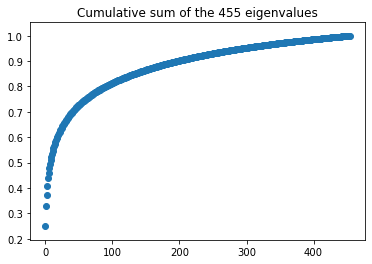

In [297]:
plot_eigen_value_distribution(eigenvalues, range(0, eigenvalues.shape[0]))
plt.title("Cumulative sum of the {0} eigenvalues".format(eigenvalues.shape[0]))
plt.show()

In [298]:
output = r" $\Lambda \to \Lambda_{principais} = \begin{bmatrix}"+str(eigenvalues[0])+r" & 0 & ... & 0 \\ 0 & "+str(eigenvalues[1])+r" & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &"+str(eigenvalues[-1])+r" \end{bmatrix}$"
md(output)

 $\Lambda \to \Lambda_{principais} = \begin{bmatrix}95731518693.15845 & 0 & ... & 0 \\ 0 & 31649354742.05785 & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &91516708.13655671 \end{bmatrix}$

In [299]:
output = r"$Q \to W$=$\begin{bmatrix}"
output += bvec(eigenvectors[0]) + r" & " + bvec(eigenvectors[1]) + r" & ... & " + bvec(eigenvectors[-1])
output += r"\end{bmatrix}$"
md(output)

$Q \to W$=$\begin{bmatrix}\begin{bmatrix}-0.00212\\-0.00228\\...\\-0.00532\end{bmatrix} & \begin{bmatrix}0.00173\\0.0019\\...\\-0.01543\end{bmatrix} & ... & \begin{bmatrix}-0.00209\\-0.00251\\...\\0.01366\end{bmatrix}\end{bmatrix}$

E podemos visualizar a conversão de vetor para imagem de alguns dos nossos autovetores, ou eigenfaces.

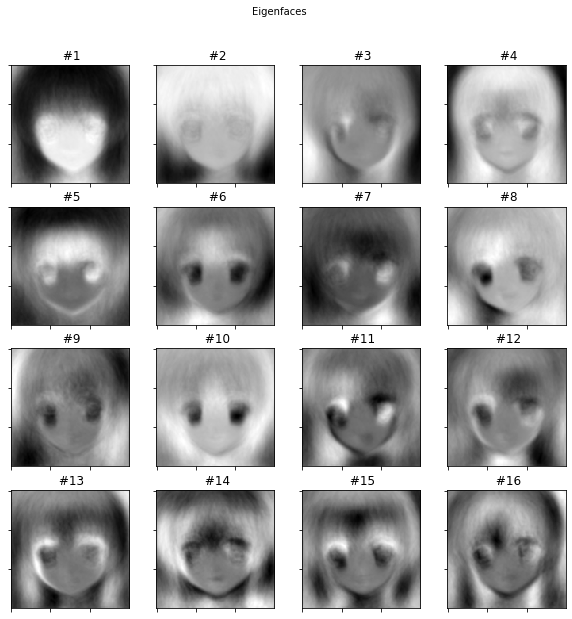

In [300]:
E = []
number = eigenvectors.shape[0]
for i in range (min(number, 16)):
    e = eigenvectors[i].reshape(DEFAULT_SIZE)
    E.append(np.asarray(e))
    
subplot ( title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="python_pca_eigenfaces.png")

Agora que conseguimos as eigenfaces, temos uma base que podemos utilizar para representar cada face.
Cada face $F$ passará a ser escrita como $F-\mu=\alpha_1 x_1 + \alpha_2 x_2+ ... + \alpha_k x_k $, com cada $x_i$ sendo uma eigenface e cada $\alpha_i$ sendo um valor real ($\mu$ é a face média), basta apenas "projetar" cada face nesse espaço para escrever elas como uma combinação linear das eigenfaces... Dessa forma, para cada face, não salvamos todos os valores de seus pixels, apenas os valores dos $\alpha$'s que multiplicam nossa base. Então:
$F = Wy + \mu$, onde $W$ é a matriz com nossas eigenfaces e $y$ são nossos $\alpha$'s.

Já possuímos $W$ e $\mu$, no primeiro caso, quando queremos projetar, $F$ é a face que projetaremos e buscamos $y$, a partir da formula acima: <br>
$y = W^{T}(F - \mu) $<br>
Para reconstruir uma face, utilizamos os valores $y$ armazenados e usamos novamente e formula:<br>
$F = Wy + \mu$


In [301]:
def project (W , X , mu):
    return np.dot (X - mu , W.T)
def reconstruct (W , Y , mu) :
    return np.dot (Y , W) + mu

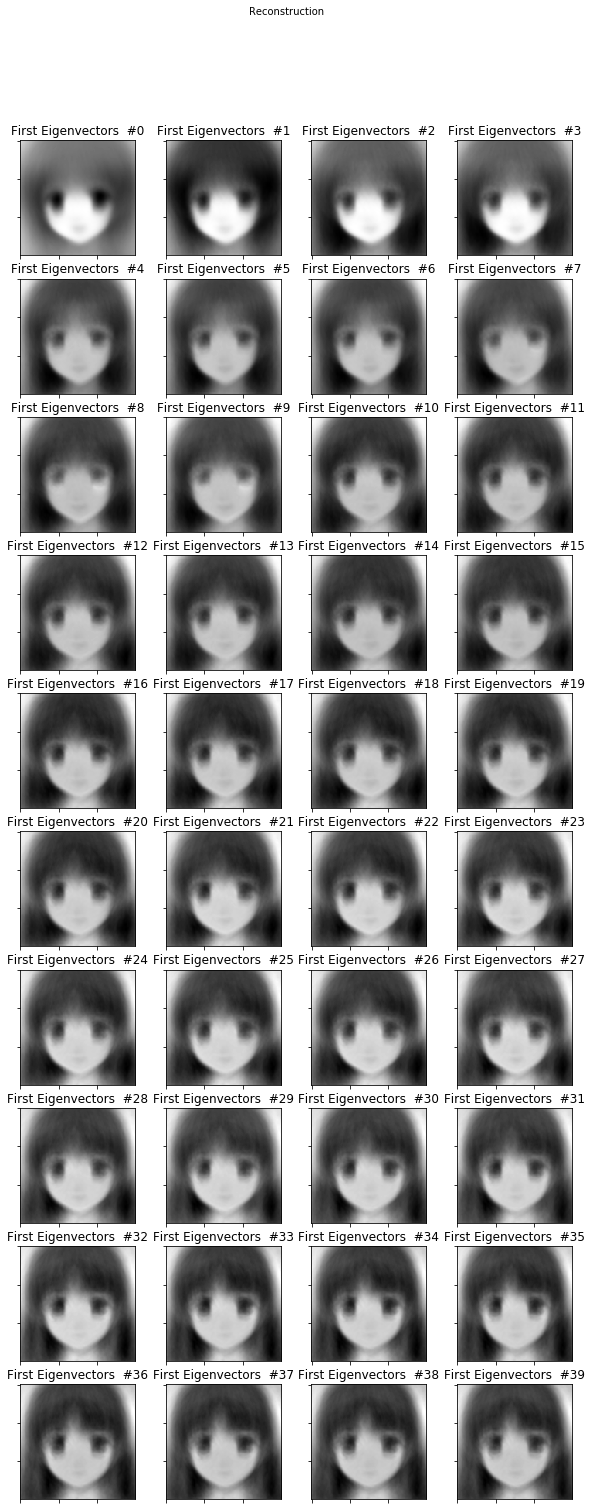

In [302]:
steps =[i for i in range (min (eigenvectors.shape[0] ,40))]
E = []

img_to_reconstruct = X[700] #Expecting a vector img

for i in range (len(steps)):
    numEvs = steps[i]
    P = project(eigenvectors[0: numEvs], img_to_reconstruct , mu)
    R = reconstruct(eigenvectors[0: numEvs], P, mu)
    # reshape and append to plots
    R = R.reshape(DEFAULT_SIZE)
    E.append(np.asarray(R))
subplot ( title ="Reconstruction", images =E, rows =10, cols =4, 
         sptitle ="First Eigenvectors ", sptitles =steps , colormap =plt.cm.gray , filename ="python_pca_reconstruction.png",figsize = (10, 25))

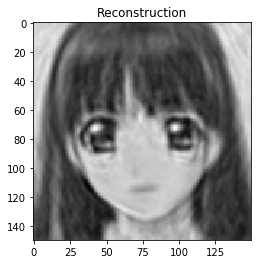

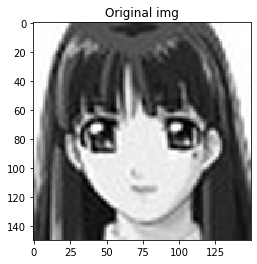

In [303]:
P = project(eigenvectors[0: -1], img_to_reconstruct , mu)
R = reconstruct(eigenvectors[0: -1], P, mu)
R = R

reconstruction = np.reshape(R, DEFAULT_SIZE)
plt.imshow(reconstruction, cmap=plt.cm.gray)
plt.title("Reconstruction")
plt.show()
original_img = np.reshape(img_to_reconstruct, DEFAULT_SIZE)
plt.imshow(original_img, cmap=plt.cm.gray)
plt.title("Original img")
plt.show()


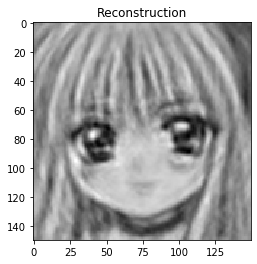

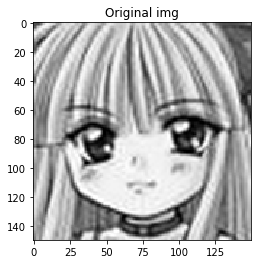

In [304]:
img_to_reconstruct = X[42]
P = project(eigenvectors[0: -1], img_to_reconstruct , mu)
R = reconstruct(eigenvectors[0: -1], P, mu)
R = R

reconstruction = np.reshape(R, DEFAULT_SIZE)
plt.imshow(reconstruction, cmap=plt.cm.gray)
plt.title("Reconstruction")
plt.show()
original_img = np.reshape(img_to_reconstruct, DEFAULT_SIZE)
plt.imshow(original_img, cmap=plt.cm.gray)
plt.title("Original img")
plt.show()

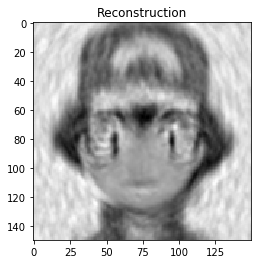

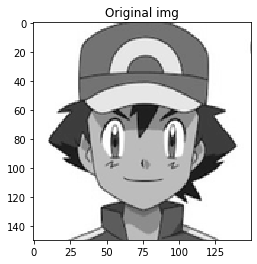

In [305]:
image = Image.open("ash.jpg")
image = image.convert ("L")
if (DEFAULT_SIZE is not None ):
    image = image.resize (DEFAULT_SIZE , Image.ANTIALIAS )
test_image = np. asarray (image , dtype =np. uint8 )
test_image = as_row_matrix([test_image])

img_to_reconstruct = test_image

P = project(eigenvectors[0: -1], img_to_reconstruct , mu)
R = reconstruct(eigenvectors[0: -1], P, mu)
R = R

reconstruction = np.reshape(R, DEFAULT_SIZE)
plt.imshow(reconstruction, cmap=plt.cm.gray)
plt.title("Reconstruction")
plt.show()
original_img = np.reshape(img_to_reconstruct, DEFAULT_SIZE)
plt.imshow(original_img, cmap=plt.cm.gray)
plt.title("Original img")
plt.show()

Assim temos a visualização de uma imagem projetada no nosso espaço das eigenfaces.
A partir disso, as eigenfaces podem ser utilizadas, por exemplo, para reconhecer imagens semelhantes, e possívelmente realizar reconhecimento facil partindo disso.

Para realizar esse tipo de comparação de imagens, comparamos a distância euclidiana entre a imagem a ser comparada com as imagens da base. A que possuir a menor distância é a mais semelhante.

Formula da distância sendo utilizada:

${\displaystyle {\begin{aligned}d(\mathbf {p} ,\mathbf {q} ) ={\sqrt {(q_{1}-p_{1})^{2}+(q_{2}-p_{2})^{2}+\cdots +(q_{n}-p_{n})^{2}}}\\[8pt]&={\sqrt {\sum _{i=1}^{n}(q_{i}-p_{i})^{2}}}.\end{aligned}}} $ 

In [306]:
def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray (q).flatten()
    return np.sqrt (np.sum (np. power ((p-q) ,2)))

In [307]:
def predict (W, mu , projections, y, img_to_predict):
    minDist = float("inf")
    minClass = -1
    Q = project (W, img_to_predict, mu)
    for i in range (len(projections)):
        dist = dist_metric( projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = i
    return minClass

In [308]:
projections = []
for xi in img_x:
    projections.append(project (eigenvectors, xi.reshape(1 , -1) , mu))

def predict (W, mu , projections, y, img_to_predict):
    minDist = float("inf")
    minClass = -1
    Q = project (W, img_to_predict, mu)
    for i in range (len(projections)):
        dist = dist_metric( projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = i
    return minClass

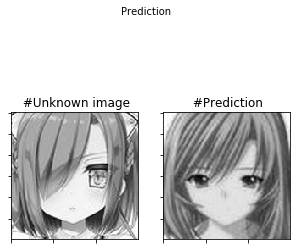

In [318]:
image = Image.open("test2.jpg")
image = image.convert ("L")
if (DEFAULT_SIZE is not None ):
    image = image.resize (DEFAULT_SIZE , Image.ANTIALIAS )
test_image = np. asarray (image , dtype =np. uint8 )
test_image = test_image.reshape(1 , -1)

predicted = predict(eigenvectors, mu , projections, y, test_image)

subplot ( title ="Prediction", images =[image, img_x[predicted]], rows =1, cols =2, 
         sptitles = ["Unknown image", "Prediction"] , colormap =plt.cm.gray , 
         filename ="prediction_test.png", figsize = (5,5))